#Installation des libraires necessaires

In [ ]:
!pip install kaggle #Pour pouvoir telecharger des datasets depuis kaggle
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path

#Téléchargement et manipulation du dossier de DataSet de fruits

In [ ]:
!kaggle datasets download -d chrisfilo/fruit-recognition #Recupere le dataset Kaggle pour la reconnaissance de fruits
!unzip fruit-recognition.zip -d fruits  # extrait le dataset telechargé dans le dossier fruits
!rm fruit-recognition.zip #supprime l'archive pr liberer de la place

##reorganisation du dossier des fruits car certains ont des sous dossiers qui ne nous interessent pas car ce sont tous des doublons du Total

In [ ]:
!rm -r fruits/Apple/'Apple A'
!rm -r fruits/Apple/'Apple B'
!rm -r fruits/Apple/'Apple C'
!rm -r fruits/Apple/'Apple D'
!rm -r fruits/Apple/'Apple E'
!rm -r fruits/Apple/'Apple F'
!mv fruits/Apple/'Total Number of Apples'/* fruits/Apple
!rm -r fruits/Apple/'Total Number of Apples'

!rm -r fruits/Guava/'Guava total'
!rm -r fruits/Guava/'guava A'
!rm -r fruits/Guava/'guava B'
!mv fruits/Guava/'guava total final'/* fruits/Guava
!rm -r fruits/Guava/'guava total final'

!rm -r fruits/Kiwi/'Kiwi B'
!rm -r fruits/Kiwi/'Kiwi C'
!rm -r fruits/Kiwi/'kiwi A'
!mv fruits/Kiwi/'Total Number of Kiwi fruit'/* fruits/Kiwi
!rm -r fruits/Kiwi/'Total Number of Kiwi fruit'
!mkdir tests

##deplacement de certaines images pour les utiliser plus tard comme test pr les predictions

In [ ]:
!ls fruits/Apple | head -n 50 | xargs -I {} mv fruits/Apple/{} tests
!ls fruits/Banana | head -n 50 | xargs -I {} mv fruits/Banana/{} tests
!ls fruits/Carambola | head -n 50 | xargs -I {} mv fruits/Carambola/{} tests
!ls fruits/Guava | head -n 50 | xargs -I {} mv fruits/Guava/{} tests
!ls fruits/Kiwi | head -n 50 | xargs -I {} mv fruits/Kiwi/{} tests
!ls fruits/Mango | head -n 50 | xargs -I {} mv fruits/Mango/{} tests
!ls fruits/Orange | head -n 50 | xargs -I {} mv fruits/Orange/{} tests
!ls fruits/Peach | head -n 50 | xargs -I {} mv fruits/Peach/{} tests
!ls fruits/Persimmon | head -n 50 | xargs -I {} mv fruits/Persimmon/{} tests
!ls fruits/Pitaya | head -n 50 | xargs -I {} mv fruits/Pitaya/{} tests
!ls fruits/Plum | head -n 50 | xargs -I {} mv fruits/Plum/{} tests
!ls fruits/Pomegranate | head -n 50 | xargs -I {} mv fruits/Pomegranate/{} tests
!ls fruits/Tomatoes | head -n 50 | xargs -I {} mv fruits/Tomatoes/{} tests
!ls fruits/muskmelon | head -n 50 | xargs -I {} mv fruits/muskmelon/{} tests

#Definition des fonctions et constantes

In [ ]:
IMG_H = 100
IMG_W = 100
data_dir = Path("fruits")

In [ ]:
##normalise les images pour reduire les données
normalization = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_H, IMG_W), #redimensionne l'image par rapport aux constantes
  tf.keras.layers.Rescaling(1./255) #Reduit les valeurs des pixels a la fourchette 0,1 au lieu de 0,255
])

##applique des modifications aleatoires sur les images pour varier le dataset
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomContrast(factor=0.5),
  tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
  tf.keras.layers.GaussianNoise(0.2)
])


In [ ]:
#Prepare les datasets d'entrainement et de validation
def train_val(batch_s, data_d, valid_s, the_seed):

  train_ds = tf.keras.utils.image_dataset_from_directory(
      data_d,
      validation_split=valid_s,
      subset="training",
      seed=the_seed,
      image_size=(IMG_H, IMG_W),
      batch_size=batch_s
  )

  val_ds = tf.keras.utils.image_dataset_from_directory(
      data_d,
      validation_split=valid_s,
      subset="validation",
      seed=the_seed,
      image_size=(IMG_H, IMG_W),
      batch_size=batch_s
  )

  return train_ds, val_ds

In [ ]:
#fonction pour compter le nombre d'un certain fruit
def compte_fruit(fruit):
  if (fruit not in class_names):
    print("attention, le fruit doit etre ecrit comme l'une des classes suivantes\n")
    print(class_names)
  return len(list(data_dir.glob(fruit+'/*')))

In [ ]:
#Permet d'afficher des fruits aleatoires (parametre aug permet de visualiser des données augmentées)
def voir_fruits(aug=False):
  plt.figure(figsize=(10, 10)) #dimensions de la figure pr visualisation
  for images, labels in train_ds.take(1): #prend le premier batch du dataset
    print(len(images))
    for i in range(9):
      ax = plt.subplot(3, 3, i+1) #les 2 premiers parametres multipliés doivent etre egal a i
      if(aug):
        image = data_augmentation(images[i])
        image = normalization(image)
        plt.imshow(image)
      else:
        plt.imshow(images[i].numpy().astype("uint8"))

      plt.title(class_names[labels[i]])
      plt.axis("off")#desactiv les axes, osef on veut juste voir les images

In [ ]:
#creation du modele dynamique (dropout pour ajouter une couche de dropout, batch_norm pour ajouter la couche de BatchNormalization)
def create_model(nb_couches, dropout=False,batch_norm=False):
  model = tf.keras.models.Sequential()
  #normalization
  model.add(tf.keras.layers.Input(shape=(IMG_H, IMG_W, 3))) #redimensionne l'image dans la taille souhaitée
  model.add(tf.keras.layers.Rescaling(1./255)) #reduit les valeurs des pixels a la fourchette 0,1


  for i in range(nb_couches):
    model.add(tf.keras.layers.Conv2D((32*(i+1)),3,activation="relu"))
    if(batch_norm):
      model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D())

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(128,activation='relu'))
  if(dropout):
    model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(len(class_names),activation='softmax'))

  return model

In [ ]:
#Permet d'afficher un graphe de l'evolution de l'entrainement du modele
def visu_entrainement(history,nb_epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(nb_epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()


#Initialisation des Datasets

In [ ]:
train_ds, val_ds = train_val(32, data_dir, 0.2, 123)# (batch_size, source, validation_split, seed)
class_names = train_ds.class_names #attribut pr visualiser les classes avec une liste
print(class_names)

Found 41606 files belonging to 15 classes.
Using 33285 files for training.
Found 41606 files belonging to 15 classes.
Using 8321 files for validation.
['Apple', 'Banana', 'Carambola', 'Guava', 'Kiwi', 'Mango', 'Orange', 'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Tomatoes', 'muskmelon']


32


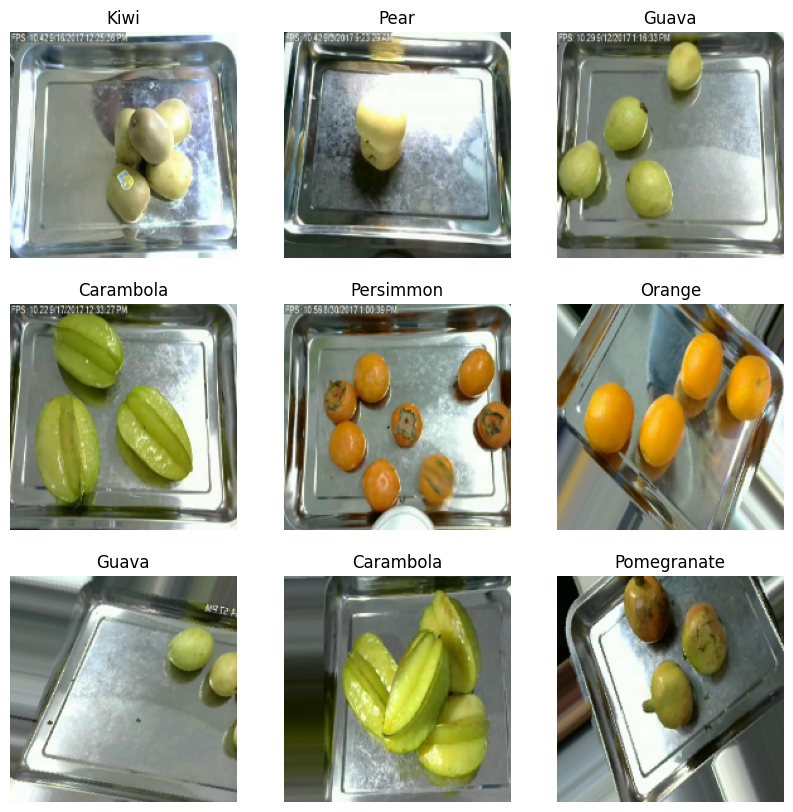

In [ ]:
voir_fruits()

32


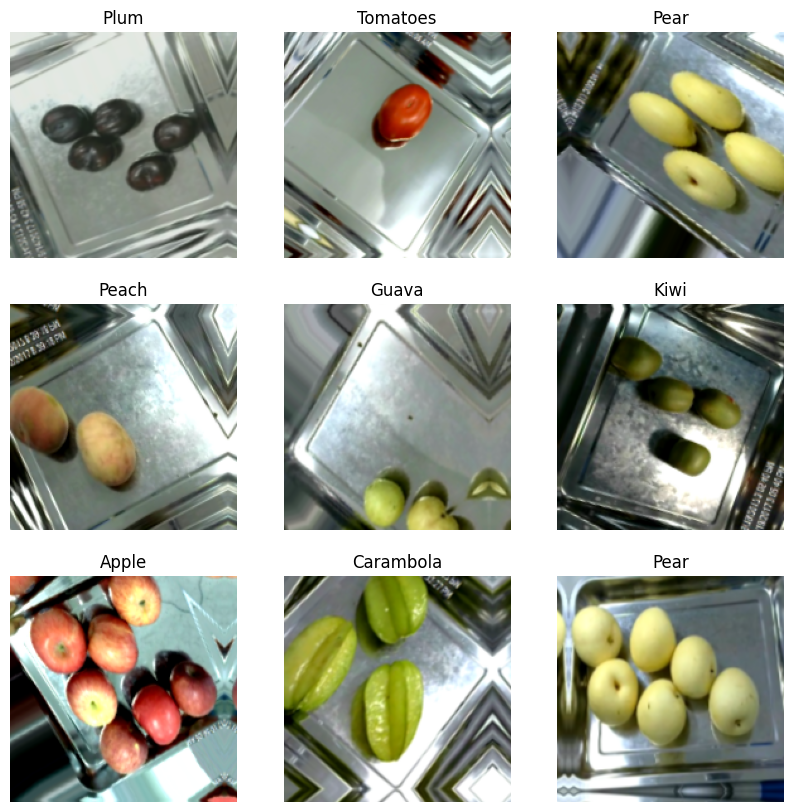

In [ ]:
voir_fruits(True) #visualisation de l'effet de la data augmentation

In [ ]:
compte_fruit("Guava")
compte_fruit("Apple")

attention, le fruit doit etre ecrit comme l'une des classes suivantes

['Apple', 'Banana', 'Carambola', 'Guava', 'Kiwi', 'Mango', 'Orange', 'Peach', 'Pear', 'Persimmon', 'Pitaya', 'Plum', 'Pomegranate', 'Tomatoes', 'muskmelon']


0

In [ ]:
##Permet de garder en memoire cache les données d'entrainement pour gagner du temps entre les epochs
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Tests de modeles avec differents parametres

##3 couches, sans dropout, sans batchNormalization

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_17 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_57 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_56 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_58 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 23, 23, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_59 (Conv2D)          (None, 21, 21, 96)      

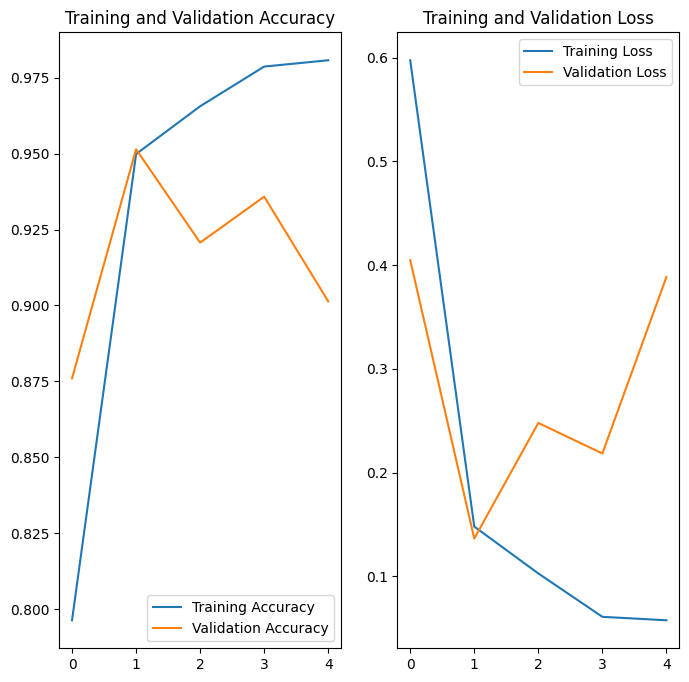

In [ ]:
modelA = create_model(3)
modelA.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)
modelA.summary()
historyA = modelA.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)
visu_entrainement(historyA,5)

##3 couches, sans dropout, avec batchNormalization

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_16 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_54 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 batch_normalization_19 (Ba  (None, 98, 98, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_53 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_20 (Ba  (None, 47, 47, 64)      

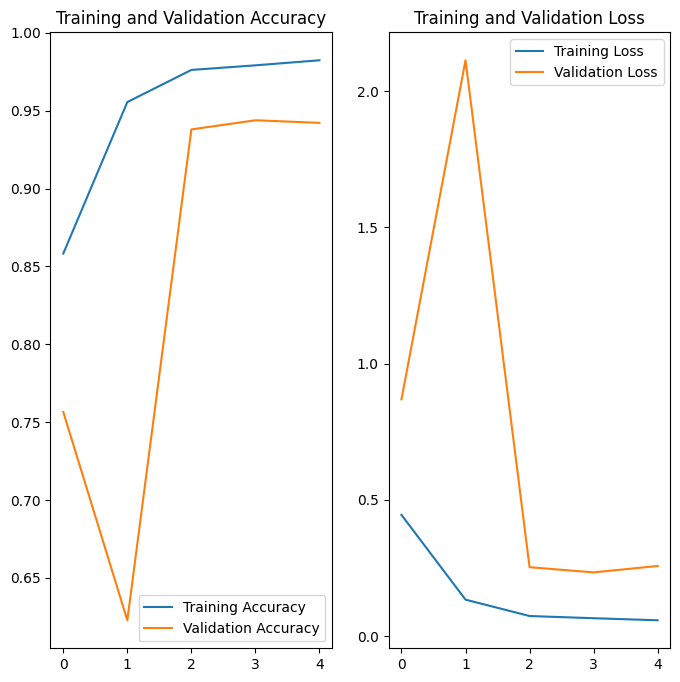

In [ ]:
modelB = create_model(3,False,True)
modelB.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)
modelB.summary()
historyB = modelB.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)
visu_entrainement(historyB,5)

##3 couches, avec dropout, sans batchNormalization

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 23, 23, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 21, 21, 96)      

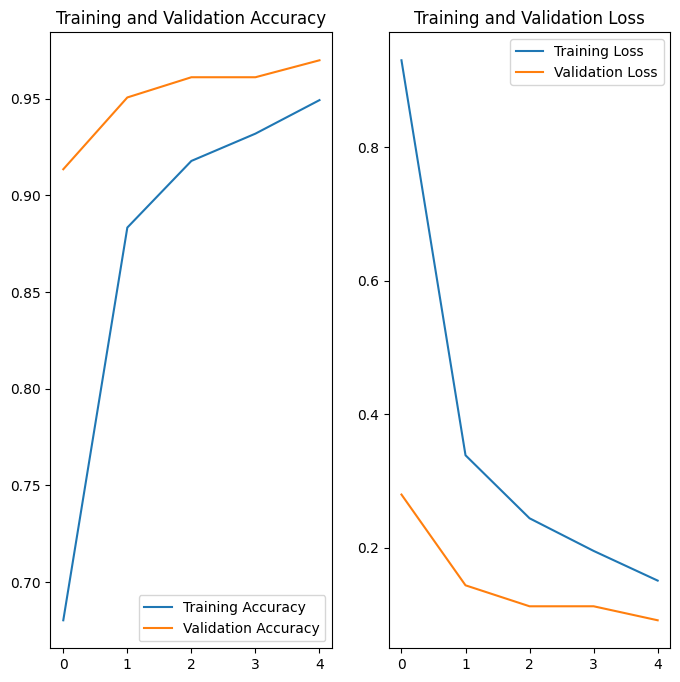

In [ ]:
modelC = create_model(3,True)
modelC.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)
modelC.summary()
historyC = modelC.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)
visu_entrainement(historyC,5)

##3 couches, avec dropout, avec batchNormalization

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 batch_normalization_6 (Bat  (None, 98, 98, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_7 (Bat  (None, 47, 47, 64)      

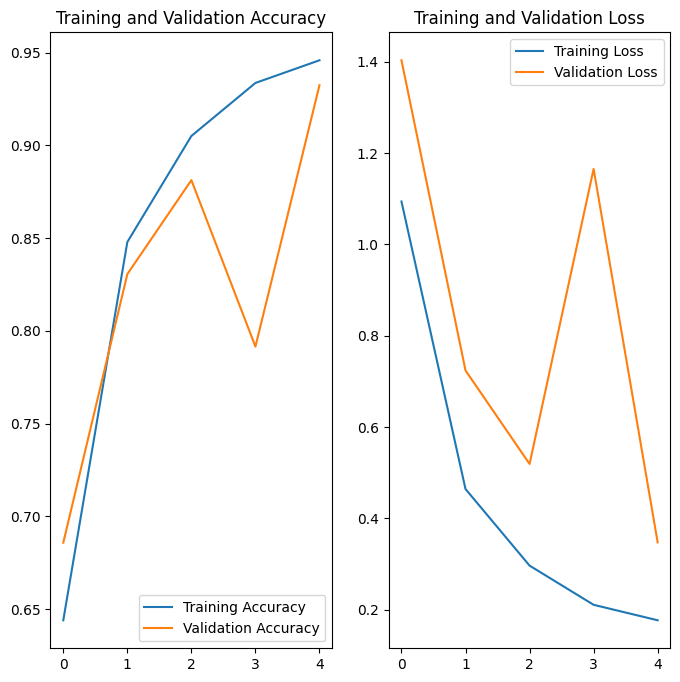

In [ ]:
modelD = create_model(3,True,True)
modelD.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)
modelD.summary()
historyD = modelD.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)
visu_entrainement(historyD,5)

##5 couches, sans dropout, sans batchNormalization

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 23, 23, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 21, 21, 96)      

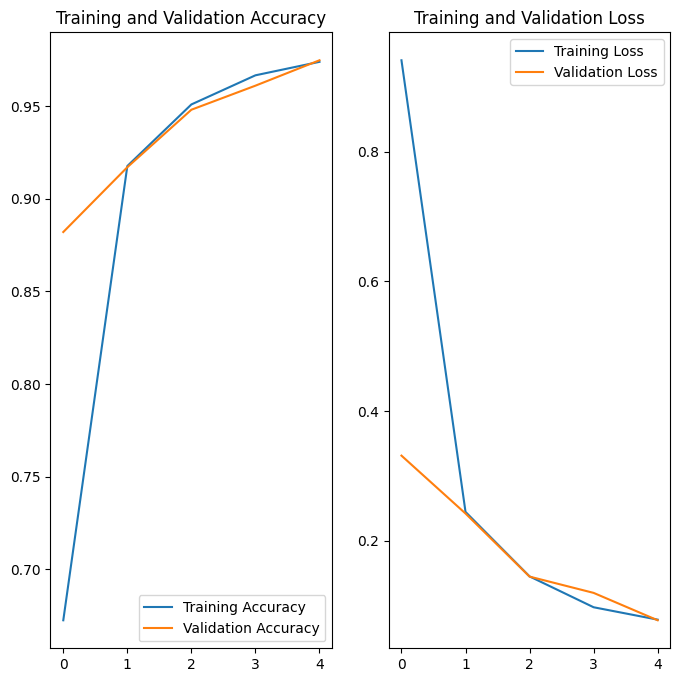

In [ ]:
modelE = create_model(5)
modelE.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)
modelE.summary()

historyE = modelE.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)
visu_entrainement(historyE,5)

##5 couches, sans dropout, avec batchNormalization

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_13 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 batch_normalization_9 (Bat  (None, 98, 98, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_10 (Ba  (None, 47, 47, 64)      

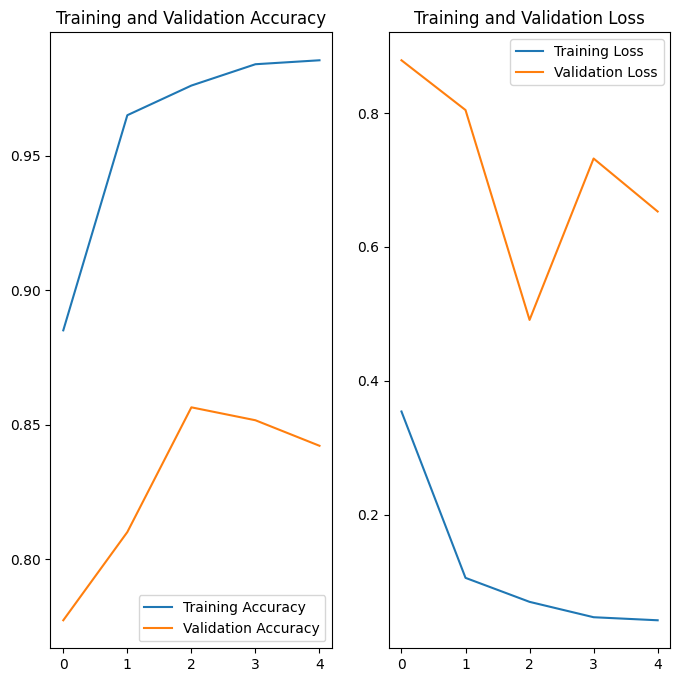

In [ ]:
modelF = create_model(5,False,True)
modelF.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)
modelF.summary()

historyF = modelF.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)
visu_entrainement(historyF,5)

##5 couches, avec dropout, sans batchNormalization

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_44 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 23, 23, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 21, 21, 96)      

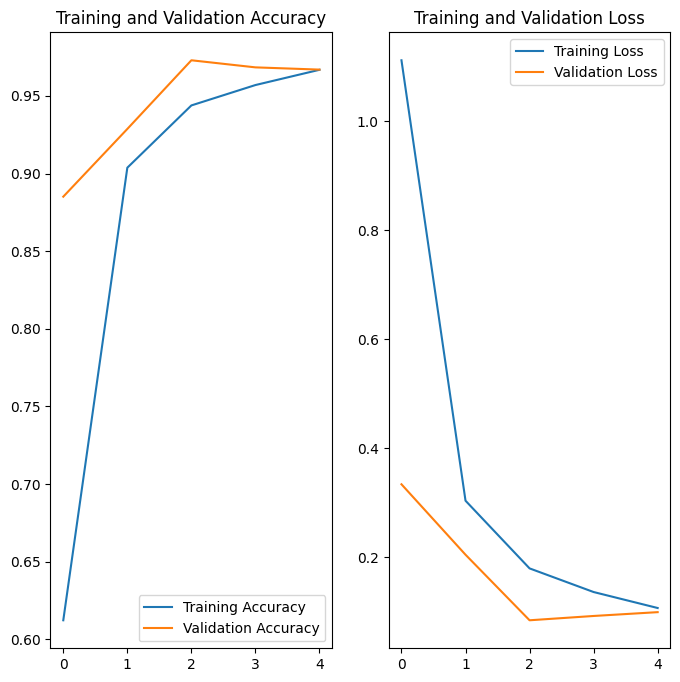

In [ ]:
modelG = create_model(5,True)
modelG.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)
modelG.summary()

historyG = modelG.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)
visu_entrainement(historyG,5)

##5 couches, avec dropout, avec batchNormalization

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_49 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 batch_normalization_14 (Ba  (None, 98, 98, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_15 (Ba  (None, 47, 47, 64)      

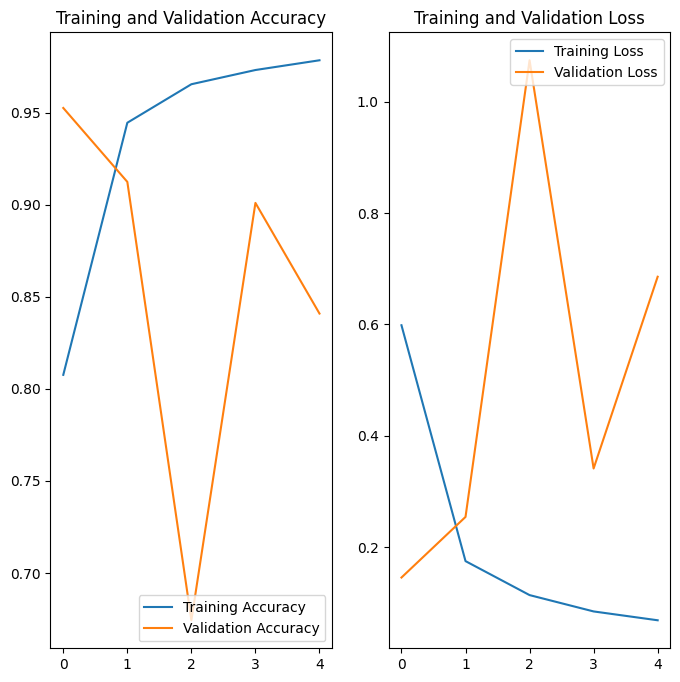

In [ ]:
modelH = create_model(5,True,True)
modelH.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)
modelH.summary()

historyH = modelH.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)
visu_entrainement(historyH,5)

#Entrainement à plus long terme sur 5 couches pour s'assurer des effets du dropout et de la batchnormalization

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_18 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_60 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_61 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 23, 23, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_62 (Conv2D)          (None, 21, 21, 96)      

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1041/1041 [==============================] - 20s 16ms/step - loss: 1.3487 - accuracy: 0.5132 - val_loss: 0.5028 - val_accuracy: 0.8314
Epoch 2/15
1041/1041 [==============================] - 17s 17ms/step - loss: 0.4244 - accuracy: 0.8596 - val_loss: 0.4378 - val_accuracy: 0.8563
Epoch 3/15
1041/1041 [==============================] - 17s 16ms/step - loss: 0.2227 - accuracy: 0.9307 - val_loss: 0.3027 - val_accuracy: 0.8954
Epoch 4/15
1041/1041 [==============================] - 18s 17ms/step - loss: 0.1528 - accuracy: 0.9517 - val_loss: 0.1506 - val_accuracy: 0.9502
Epoch 5/15
1041/1041 [==============================] - 14s 14ms/step - loss: 0.1081 - accuracy: 0.9669 - val_loss: 0.0924 - val_accuracy: 0.9688
Epoch 6/15
1041/1041 [==============================] - 14s 14ms/step - loss: 0.0959 - accuracy: 0.9699 - val_loss: 0.1368 - val_accuracy: 0.9582
Epoch 7/15
1041/1041 [==============================] - 15s 14ms/step - loss: 0.0819 - accuracy: 0.9769 - val_loss: 0.1028 - val_accura

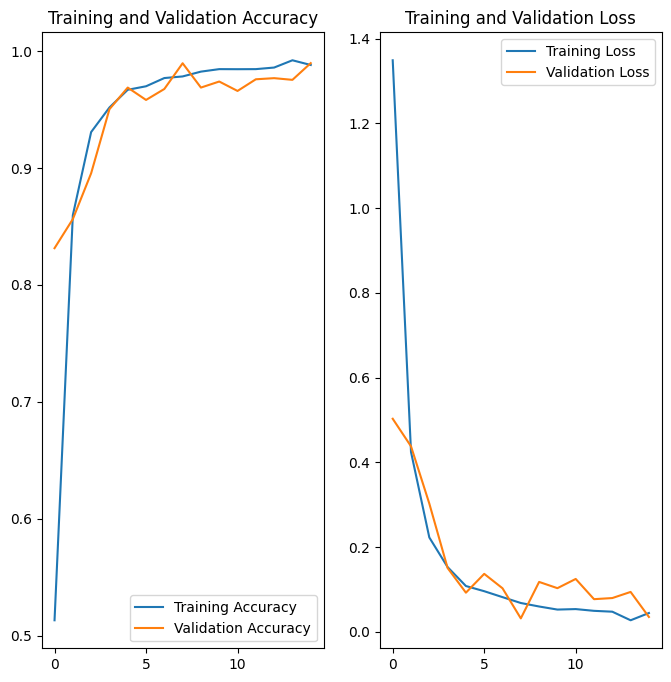

In [ ]:
modelPlusA = create_model(5,True)
modelPlusA.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)
modelPlusA.summary()
historyPlusA = modelPlusA.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)
visu_entrainement(historyPlusA,15)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_19 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_65 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 batch_normalization_22 (Ba  (None, 98, 98, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_64 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_66 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_23 (Ba  (None, 47, 47, 64)      

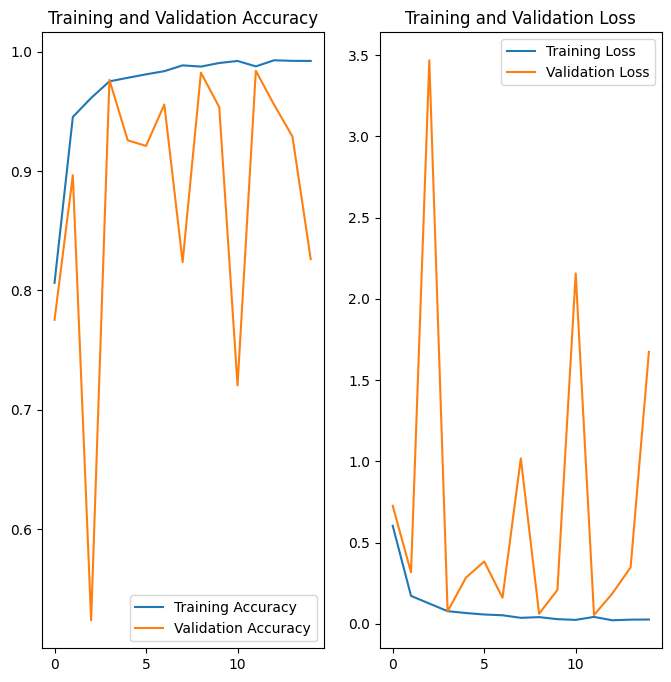

In [ ]:
modelPlusB = create_model(5,True,True)
modelPlusB.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)
modelPlusB.summary()
historyPlusB = modelPlusB.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)
visu_entrainement(historyPlusB,15)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_20 (Rescaling)    (None, 100, 100, 3)       0         
                                                                 
 conv2d_70 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_69 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_71 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_70 (MaxPooli  (None, 23, 23, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_72 (Conv2D)          (None, 21, 21, 96)      

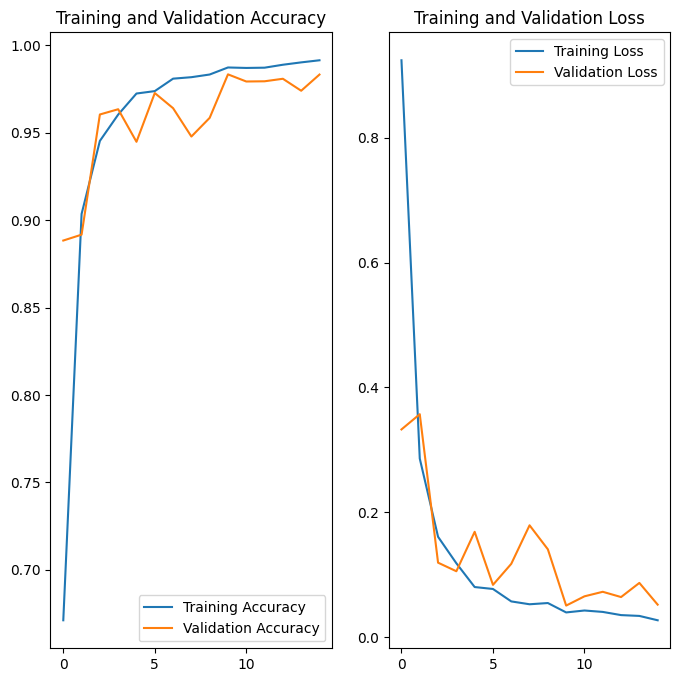

In [ ]:
modelPlusC = create_model(5)
modelPlusC.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)
modelPlusC.summary()
historyPlusC = modelPlusC.fit(
  train_ds,
  validation_data=val_ds,
  epochs=15
)
visu_entrainement(historyPlusC,15)

#Entrainement Final sur les parametres de modèle s'etant montré les plus efficace

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 21, 21, 96)       

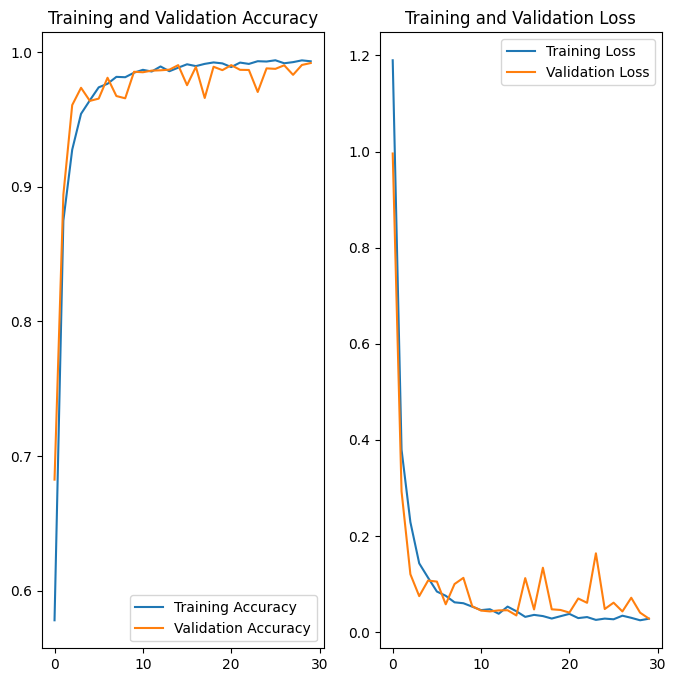

In [ ]:
modelFinal = create_model(5,True)
modelFinal.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)
modelFinal.summary()
historyFinal = modelFinal.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30
)
visu_entrainement(historyFinal,30)

#Predictions du modele sur notre dossier d'images de tests

1/1 [==============================] - 0s 24ms/step


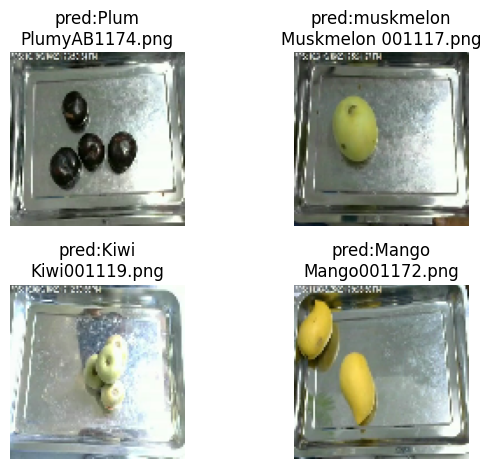

In [ ]:
import random
import os
test_ds = os.listdir("tests")

for i in range(4):
  ax = plt.subplot(2, 2, i+1) #les 2 premiers parametres multipliés doivent etre egal a i
  reponse = random.choice(test_ds)
  rand_img = Path("tests/"+reponse)
  img = tf.keras.utils.load_img(
  rand_img, target_size=(IMG_H, IMG_W)
  )
  img_array = tf.keras.utils.img_to_array(img)
  plt.imshow(normalization(img_array))
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = modelFinal.predict(img_array)
  score = tf.nn.softmax(predictions[0])



  plt.title("pred:"+class_names[np.argmax(score)]+"\n"+reponse)
  plt.axis("off")#desactiv les axes, osef on veut juste voir les images
plt.tight_layout()